In [4]:
################## IMPORT LIBRARIES ##################
import soundfile as sf
from IPython.display import Audio
import numpy as np
import random 
import pandas as pd
import os
from os.path import join as pjoin
import tqdm
from acoustics.bands import third
import scipy.signal as sig
from IPython.display import Audio
# from masp import shoebox_room_sim as srs
from scipy.io import wavfile
#import mat73
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (4, 3)
import torch 
import sklearn 


In [111]:
################## IMPORT MY MODULES ##################

import sys
sys.path.append('../src')
import joa_helpers as hlp
import cond_waveunet_dataset as dset
import cond_waveunet_model as cwaveunet
from cond_waveunet_traintest import infer
import cond_waveunet_eval as eval
import importlib
importlib.reload(hlp)
importlib.reload(dset)
importlib.reload(cwaveunet)
importlib.reload(eval)

<module 'cond_waveunet_eval' from '/home/ubuntu/joanna/reverb-match-cond-u-net/notebooks/../src/cond_waveunet_eval.py'>

### <font color='fuchsia'>Inspect datapoints:</font>

In [132]:
################## LOAD TRAINING PARAMETERS  ##################

# load arguments used for training

# ---- results coming from experiment 18-11-2023 (Training for about 30 epochs): ----
# # a) many to many
# args_mtm=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/19-11-2023--06-13_many-to-many_lr-0.0001_bs-24/trainargs.pt")
# train_results_mtm=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/19-11-2023--06-13_many-to-many_lr-0.0001_bs-24/checkpoint27.pt",map_location=args_mtm.device)
# # b) one-to-many 
# args_1tm=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/20-11-2023--10-23_one-to-many_lr-0.0001_bs-8/trainargs.pt")
# train_results_1tm=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-18-11-2023/20-11-2023--10-23_one-to-many_lr-0.0001_bs-8/checkpoint27.pt",map_location=args_1tm.device)

# ---- results coming from experiment 11-12-2023 (Training for about 100 epochs (early stopping) for the best parameter combinations: ----
# # a) many to many
# args_mtm=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-11-12-2023/11-12-2023--16-25_many-to-many_lr-0.0001_bs-8/trainargs.pt")
# train_results_mtm=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-11-12-2023/11-12-2023--16-25_many-to-many_lr-0.0001_bs-8/checkpoint120.pt",map_location=args_mtm.device)
# # b) one-to-many 
# args_1tm=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-11-12-2023/12-12-2023--16-26_one-to-many_lr-0.0001_bs-8/trainargs.pt")
# train_results_1tm=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-11-12-2023/12-12-2023--16-26_one-to-many_lr-0.0001_bs-8/checkpoint90.pt",map_location=args_1tm.device)

# ---- results coming from experiment 12-01-2024 (Training for 100 epochs for different losses): ----
# a) many to many
args_mtm=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-12-01-2024/13-01-2024--10-33_many-to-many_stft+rev/trainargs.pt")
train_results_mtm=torch.load("/home/ubuntu/Data/RESULTS-reverb-match-cond-u-net/runs-exp-12-01-2024/13-01-2024--10-33_many-to-many_stft+rev/checkpoint_best.pt",map_location=args_mtm.device)




In [133]:
################## CHOOSE WHAT DO INSPECT: ONE-TO-MANY OR MANY-TO-MANY ##################

# one-to-many:
# args=args_1tm
# train_results=train_results_1tm

# many-to-many:
args=args_mtm
train_results=train_results_mtm

In [134]:
################## LOAD DATASET AND CHECK 1 DATAPOINT SAMPLE  ##################

# instantiate a test data set 
args.split="test"
dataset=dset.DatasetReverbTransfer(args)
# get one data sample 
sContent, sStyle, sTarget, sAnecho = dataset[0]

# playback for the data sample
audios=[sContent, sStyle, sTarget,]
names=["sContent", "sStyle", "sTarget"]

for i,audio in enumerate(audios):
    print(names[i])
    audio=audio.squeeze(0).cpu()
    display(Audio(audio,rate=48e3))


sContent


sStyle


sTarget


###  <font color='fuchsia'>Inspect inference with trained models:</font>

In [135]:
################## LOAD MODELS AND TRAINING WEIGHTS  ##################


# load reverb encoder
model_ReverbEncoder=cwaveunet.ReverbEncoder(args)
model_ReverbEncoder.to("cuda")
model_ReverbEncoder.eval()
# check waveunet 
model_waveunet=cwaveunet.waveunet(args)
model_waveunet.to("cuda")
model_waveunet.eval()
# load training results
model_waveunet.load_state_dict(train_results["model_waveunet_state_dict"])
model_ReverbEncoder.load_state_dict(train_results["model_reverbenc_state_dict"])


<All keys matched successfully>

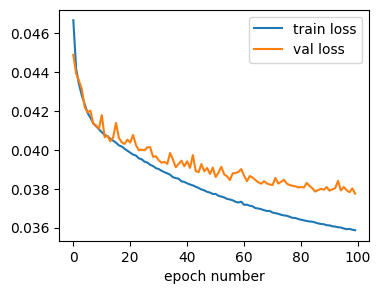

In [136]:
################## PLOT TRAINING LOSS EVOLUTION  ##################

# load and plot the loss evolution 
loss = list(zip(*train_results['loss']))
plt.figure()
plt.plot(loss[0],label="train loss")
plt.plot(loss[1],label="val loss")
plt.xlabel("epoch number")
plt.legend()
plt.show()

In [144]:
################## SEARCH FOR DATA POINTS FROM TEST SET WITH SPECIFIC PROPERTIES   ##################

df_dataset=pd.read_csv('nonoise2_data_set.csv')
df_dataset=df_dataset[df_dataset["split"]=="test"]
custom_index = np.repeat(np.arange(len(df_dataset)//2), 2)
df_dataset = df_dataset.copy() # to prevent "SettingWithCopy" warning
df_dataset.loc[:, "pair_idx"] = custom_index

# create column diff_rt60 to compute difference in rt60 between content and style audio
df_dataset["diff_rt60"] = df_dataset["rt60_true"].diff()
df_dataset["diff_rt60"][0::2]=df_dataset["diff_rt60"][1::2]

# check indices of datapoint where the rt60 for content is lower than rt60 for style
print(df_dataset.loc[df_dataset["diff_rt60"]>0.8,"pair_idx"])

100814       7
100815       7
101540     370
101541     370
101848     524
          ... 
112711    5955
112824    6012
112825    6012
113334    6267
113335    6267
Name: pair_idx, Length: 100, dtype: int64


/tmp/ipykernel_2536558/817705263.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset["diff_rt60"][0::2]=df_dataset["diff_rt60"][1::2]


In [151]:
################## INFERENCE FOR ONE DATA SAMPLE  ##################

def infer(model_reverbenc, model_waveunet, data, device):
    with torch.no_grad():
        # Function to infer target audio
        # ------------------------------
        # get datapoint
        sContent = data[0].to(device)
        sStyle=data[1].to(device)
        sTarget=data[2].to(device)
        # forward pass - get prediction of the ir
        embedding_gt=model_reverbenc(sStyle.unsqueeze(0))
        sPrediction=model_waveunet(sContent.unsqueeze(0),embedding_gt)
        return sContent, sStyle, sTarget, sPrediction

sContent, sStyle, sTarget, sPrediction =infer(model_ReverbEncoder, model_waveunet, dataset[6012], args.device)

sContent:


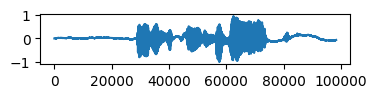

sStyle:


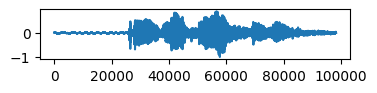

sTarget:


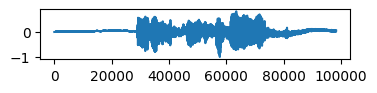

sPrediction:


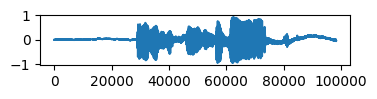

In [152]:
################## PLOT AND PLAY BACK CONTENT, STYLE, TARGET AND PREDICTION ##################

audios=[sContent, sStyle, sTarget, sPrediction]
names=["sContent", "sStyle", "sTarget", "sPrediction"]

plt.figure()
for i,audio in enumerate(audios):
    print(names[i]+":")
    plt.subplot(4,1,i+1)
    audio=audio.squeeze(0).cpu()
    if i==3:
        audio=audio.squeeze(0)
    plt.plot(audio)
    plt.show()
    display(Audio(audio,rate=48e3))


###  <font color='fuchsia'>Evaluation of the latent space</font>

In [9]:
################## GENERATE EMBEDDING ARRAY AND PARAMETER ARRAYS FROM MULTIPLE DATA POINTS ##################

emb_arr=np.zeros([len(dataset),512])
rt30_meas_arr=np.zeros([len(dataset),1])
edt_meas_arr=np.zeros([len(dataset),1])
c50_meas_arr=np.zeros([len(dataset),1])
rt60_set_arr=np.zeros([len(dataset),1])
rt60_true_arr=np.zeros([len(dataset),1])
for j,data in enumerate(dataset):
    # get style audio
    sStyle_in=data[1]
    # get style info
    df_Style=dataset.get_info(j,style=True)
    # get style embedding of size 512
    with torch.no_grad():
        embedding=model_ReverbEncoder(sStyle_in.unsqueeze(0).to(args.device))
        emb_arr[j,:]=embedding.cpu().numpy()
    rt30_meas_arr[j]=df_Style["rt30_meas"]
    rt60_set_arr[j]=df_Style["rt60_set"]
    rt60_true_arr[j]=df_Style["rt60_true"]
    edt_meas_arr[j]=df_Style["edt_meas"]
    c50_meas_arr[j]=df_Style["c50_meas"]
    if j==1000:
        break


In [10]:
################## PERFORM DIMENSIONALITY REDUCTION ON THE EMBEDDING SPACE ##################

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

indices_subset=range(1000)
# reduce dimensionality of the embeddings
# using pca:
embeddings_pca=PCA(n_components=2).fit_transform(emb_arr[indices_subset,:])
# using first pca and then tsne:
embeddings_pca_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(PCA(n_components=50).fit_transform(emb_arr[indices_subset,:]))
# using tsne:
embeddings_tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(emb_arr[indices_subset,:])

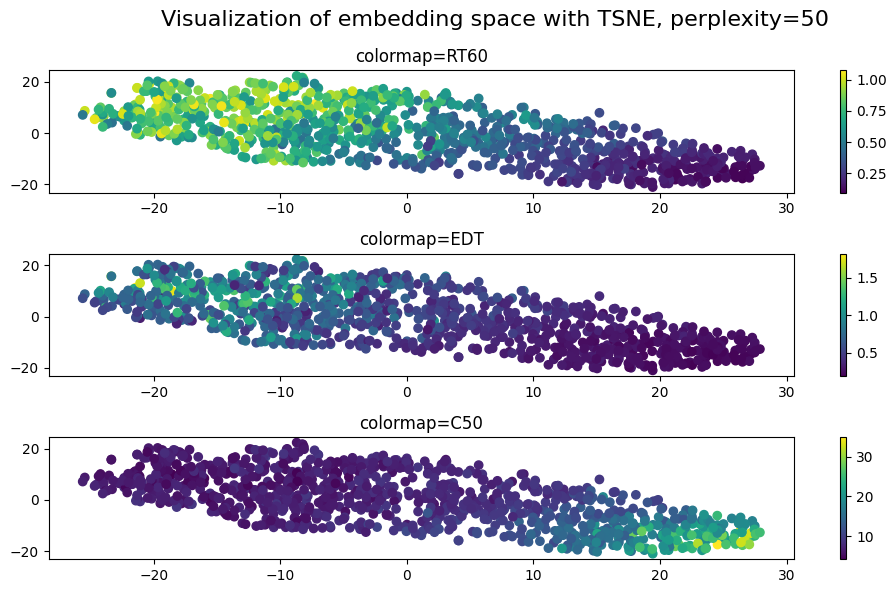

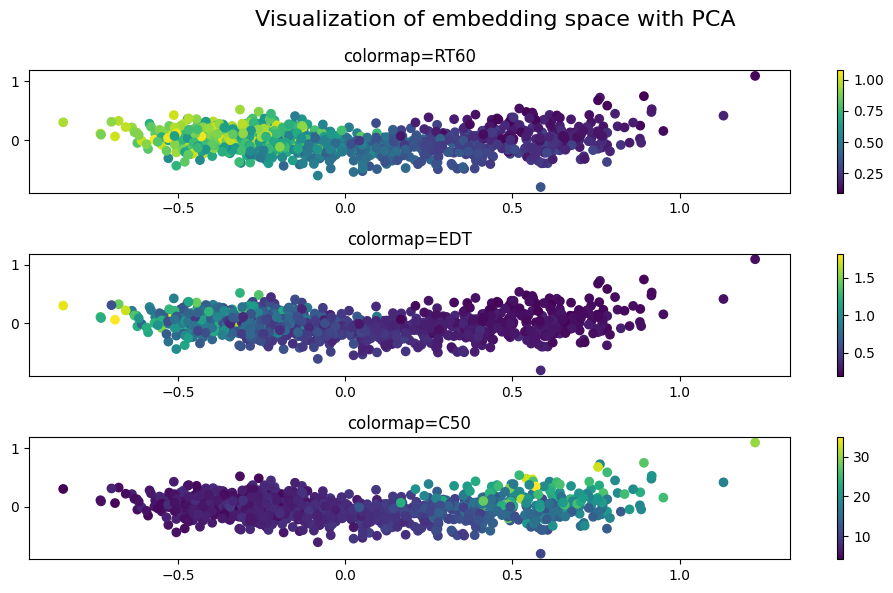

In [11]:
################## PLOT TSNE 2-DIM VISUALISATION OF THE EMBEDDING SPACE ##################

# plt.figure(figsize=(10,6))
# plt.suptitle('Visualization of embeddings with TSNE, perplexity=50', fontsize=16)
# plt.subplot(2,3,1)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt30_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt30 meas')
# plt.subplot(2,3,2)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt60 meas')
# plt.subplot(2,3,3)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_set_arr[indices_subset]);plt.colorbar();plt.title('colormap=rt60 set')
# plt.subplot(2,3,4)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=edt')
# plt.subplot(2,3,5)
# plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=c50')
# cmap = plt.get_cmap('cool')
# plt.set_cmap(cmap)


plt.figure(figsize=(10,6))
plt.suptitle('Visualization of embedding space with TSNE, perplexity=50', fontsize=16)
plt.subplot(3,1,1)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(3,1,2)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(3,1,3)
plt.scatter(embeddings_tsne[:,0] , embeddings_tsne[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=C50')

plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
plt.suptitle('Visualization of embedding space with PCA', fontsize=16)
plt.subplot(3,1,1)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=rt60_true_arr[indices_subset]);plt.colorbar();plt.title('colormap=RT60')
plt.subplot(3,1,2)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=edt_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=EDT')
plt.subplot(3,1,3)
plt.scatter(embeddings_pca[:,0] , embeddings_pca[:,1], c=c50_meas_arr[indices_subset]);plt.colorbar();plt.title('colormap=C50')

plt.tight_layout()
plt.show()